# [Paris Saclay Center for Data Science](http://www.datascience-paris-saclay.fr)

## [Titanic RAMP](http://www.ramp.studio/problems/titanic): survival prediction of Titanic passengers

_Benoit Playe (Institut Curie/Mines ParisTech), Chloé-Agathe Azencott (Institut Curie/Mines ParisTech), Alex Gramfort (Inria), Balázs Kégl (LAL/CNRS)_

## Introduction
This is an initiation project to introduce RAMP and get you to know how it works.

The goal is to develop prediction models able to **identify people who survived from the sinking of the Titanic, based on gender, age, and ticketing information**. 

The data we will manipulate is from the [Titanic kaggle challenge](https://www.kaggle.com/c/titanic-gettingStarted).

### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.19.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)   
* seaborn>=0.7.1

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [2]:
train_filename = 'data/train.csv'
data = pd.read_csv(train_filename)
y_df = data['Survived']
X_df = data.drop(['Survived', 'PassengerId'], axis=1)
X_df.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",female,29.0,0,4,349909,21.075,NaN,S
1,2,"Beane, Mr. Edward",male,32.0,1,0,2908,26.000,NaN,S
2,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.075,NaN,S
3,3,"Torber, Mr. Ernst William",male,44.0,0,0,364511,8.050,NaN,S
4,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.000,NaN,S


In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,356.000000,356.000000,356.000000,290.000000,356.000000,356.000000,356.000000
mean,451.713483,0.384831,2.300562,29.123862,0.550562,0.412921,31.657970
std,260.505039,0.487240,0.833861,14.103122,1.120978,0.798415,43.474154
min,7.000000,0.000000,1.000000,0.920000,0.000000,0.000000,0.000000
25%,229.750000,0.000000,2.000000,19.000000,0.000000,0.000000,7.925000
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,15.245800
75%,686.750000,1.000000,3.000000,37.000000,1.000000,1.000000,31.275000
max,890.000000,1.000000,3.000000,71.000000,8.000000,6.000000,263.000000


In [4]:
data.count()

PassengerId    356
Survived       356
Pclass         356
Name           356
Sex            356
Age            290
SibSp          356
Parch          356
Ticket         356
Fare           356
Cabin           83
Embarked       356
dtype: int64

The original training data frame has 891 rows. In the starting kit, we give you a subset of 445 rows. Some passengers have missing information: in particular `Age` and `Cabin` info can be missing. The meaning of the columns is explained on the [challenge website](https://www.kaggle.com/c/titanic-gettingStarted/data):

### Predicting survival

The goal is to predict whether a passenger has survived from other known attributes. Let us group the data according to the `Survived` columns:

In [5]:
data.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,219,219,219,219,179,219,219,219,219,27,219
1,137,137,137,137,111,137,137,137,137,56,137


About two thirds of the passengers perished in the event. A dummy classifier that systematically returns "0" would have an accuracy of 62%, higher than that of a random model.

### Some plots

#### Features densities and co-evolution
A scatterplot matrix allows us to visualize:
* on the diagonal, the density estimation for each feature
* on each of the off-diagonal plots, a scatterplot between two features. Each dot represents an instance.

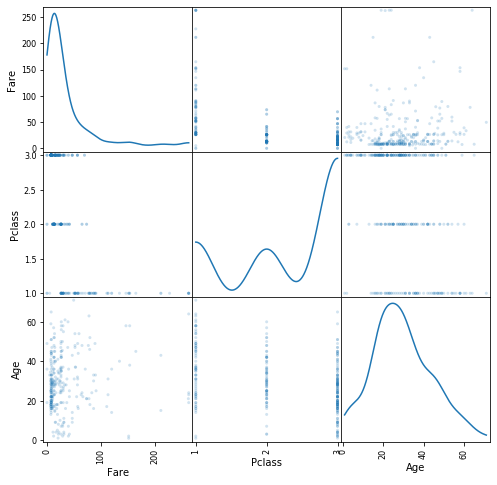

In [6]:
from pandas.plotting import scatter_matrix
scatter_matrix(data.get(['Fare', 'Pclass', 'Age']), alpha=0.2,
               figsize=(8, 8), diagonal='kde');

#### Non-linearly transformed data

The `Fare` variable has a very heavy tail. We can log-transform it. 

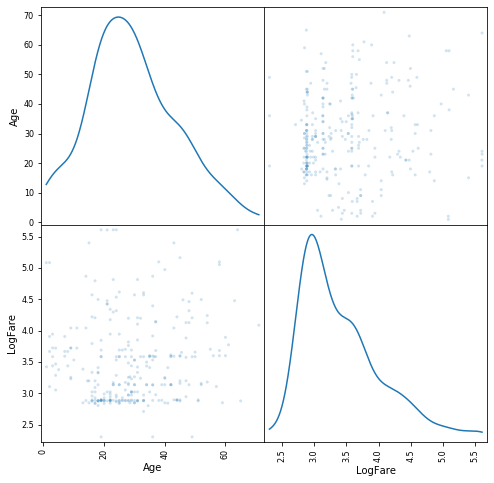

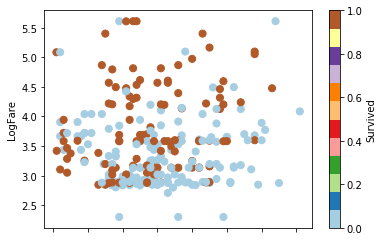

In [7]:
data_plot = data.get(['Age', 'Survived'])
data_plot = data.assign(LogFare=lambda x : np.log(x.Fare + 10.))
scatter_matrix(data_plot.get(['Age', 'LogFare']), alpha=0.2, figsize=(8, 8), diagonal='kde');

data_plot.plot(kind='scatter', x='Age', y='LogFare', c='Survived', s=50, cmap=plt.cm.Paired);

#### Plot the bivariate distributions and marginals of two variables 

Another way of visualizing relationships between variables is to plot their bivariate distributions.

/Users/alex/anaconda/envs/mne/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/alex/anaconda/envs/mne/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


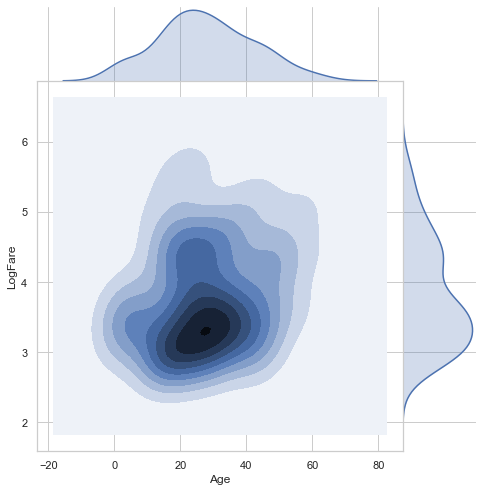

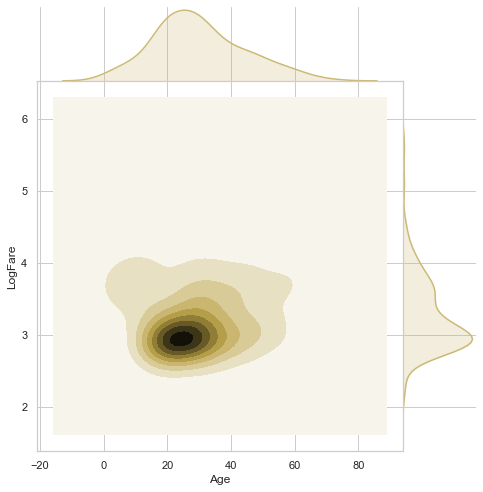

In [8]:
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.jointplot(data_plot.Age[data_plot.Survived == 1],
              data_plot.LogFare[data_plot.Survived == 1],
              kind="kde", size=7, space=0, color="b");

sns.jointplot(data_plot.Age[data_plot.Survived == 0],
              data_plot.LogFare[data_plot.Survived == 0],
              kind="kde", size=7, space=0, color="y");

## The pipeline

For submitting at the [RAMP site](http://ramp.studio), you will have to write two classes, saved in two different files:   
* the class `FeatureExtractor`, which will be used to extract features for classification from the dataset and produce a numpy array of size (number of samples $\times$ number of features). 
* a class `Classifier` to predict survival

### Feature extractor

The feature extractor implements a `transform` member function. It is saved in the file [`submissions/starting_kit/feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py). It receives the pandas dataframe `X_df` defined at the beginning of the notebook. It should produce a numpy array representing the extracted features, which will then be used for the classification.  

Note that the following code cells are *not* executed in the notebook. The notebook saves their contents in the file specified in the first line of the cell, so you can edit your submission before running the local test below and submitting it at the RAMP site.

In [9]:
%%file submissions/starting_kit/feature_extractor.py
import pandas as pd


class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_df_new = pd.concat(
            [X_df.get(['Fare', 'Age', 'SibSp', 'Parch']),
             pd.get_dummies(X_df.Sex, prefix='Sex', drop_first=True),
             pd.get_dummies(X_df.Pclass, prefix='Pclass', drop_first=True),
             pd.get_dummies(
                 X_df.Embarked, prefix='Embarked', drop_first=True)],
            axis=1)
        X_df_new = X_df_new.fillna(-1)
        XX = X_df_new.values
        return XX



Overwriting submissions/starting_kit/feature_extractor.py


### Classifier

The classifier follows a classical scikit-learn classifier template. It should be saved in the file [`submissions/starting_kit/classifier.py`](/edit/submissions/starting_kit/classifier.py). In its simplest form it takes a scikit-learn pipeline, assigns it to `self.clf` in `__init__`, then calls its `fit` and `predict_proba` functions in the corresponding member funtions.

In [10]:
%%file submissions/starting_kit/classifier.py
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('classifier', LogisticRegression(C=1., solver='liblinear'))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)



Overwriting submissions/starting_kit/classifier.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `classifier.py` and `feature_extractor.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [11]:
!ramp_test_submission

Testing Titanic survival classification
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score   auc   acc   nll      time
	train  0.84  0.79  0.47  0.099792
	valid  0.92  0.83  0.38  0.004877
	test   0.86  0.84  0.43  0.004598
CV fold 1
	score   auc   acc   nll      time
	train  0.85  0.82  0.46  0.008975
	valid  0.86  0.78  0.46  0.004814
	test   0.84  0.83  0.46  0.005700
CV fold 2
	score   auc   acc   nll      time
	train  0.87  0.79  0.44  0.010463
	valid  0.80  0.82  0.49  0.005203
	test   0.86  0.84  0.44  0.004919
CV fold 3
	score   auc   acc   nll      time
	train  0.85  0.81  0.46  0.009368
	valid  0.87  0.81  0.43  0.004268
	test   0.86  0.85  0.43  0.004622
CV fold 4
	score   auc   acc   nll      time
	train  0.85  0.82  0.45  0.007694
	valid  0.84  0.79  0.47  0.005826
	test   0.84  0.82  0.45  0.006834
CV fold 5
	score   auc   acc   nll      time
	train  0.84  0.80  0.46  0.009893
	valid  0.88  0.78  0.42  0.0051

## Submitting to [ramp.studio](http://ramp.studio)

Once you found a good feature extractor and classifier, you can submit them to [ramp.studio](http://www.ramp.studio). First, if it is your first time using RAMP, [sign up](http://www.ramp.studio/sign_up), otherwise [log in](http://www.ramp.studio/login). Then find an open event on the particular problem, for example, the event [titanic](http://www.ramp.studio/events/titanic) for this RAMP. Sign up for the event. Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](http://www.ramp.studio/events/titanic/sandbox) and copy-paste (or upload) [`feature_extractor.py`](/edit/submissions/starting_kit/feature_extractor.py) and [`classifier.py`](/edit/submissions/starting_kit/classifier.py) from `submissions/starting_kit`. Save it, rename it, then submit it. The submission is trained and tested on our backend in the same way as `ramp_test_submission` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](http://www.ramp.studio/events/titanic/my_submissions). Once it is trained, you get a mail, and your submission shows up on the [public leaderboard](http://www.ramp.studio/events/titanic/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp_test_submission`), it will show up in the "Failed submissions" table in [my submissions](http://www.ramp.studio/events/titanic/my_submissions). You can click on the error to see part of the trace.

After submission, do not forget to give credits to the previous submissions you reused or integrated into your submission.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, perhaps do some AutoML/hyperopt, etc., _locally_, and checking them with `ramp_test_submission`. The script prints mean cross-validation scores 
```
----------------------------
train auc = 0.85 ± 0.005
train acc = 0.81 ± 0.006
train nll = 0.45 ± 0.007
valid auc = 0.87 ± 0.023
valid acc = 0.81 ± 0.02
valid nll = 0.44 ± 0.024
test auc = 0.83 ± 0.006
test acc = 0.76 ± 0.003
test nll = 0.5 ± 0.005
```
The official score in this RAMP (the first score column after "historical contributivity" on the [leaderboard](http://www.ramp.studio/events/titanic/leaderboard)) is area under the roc curve ("auc"), so the line that is relevant in the output of `ramp_test_submission` is `valid auc = 0.87 ± 0.023`. When the score is good enough, you can submit it at the RAMP.

## Other models in the starting kit

You can also keep several other submissions in your work directory [`submissions`](/tree/submissions). [`random_forest_20_5`](/tree/submissions/random_forest_20_5) uses the same feature extractor as [`starting_kit`](/tree/submissions/starting_kit) but another classifier.

In [12]:
%%file submissions/random_forest_20_5/feature_extractor.py
import pandas as pd


class FeatureExtractor():
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass

    def transform(self, X_df):
        X_df_new = pd.concat(
            [X_df.get(['Fare', 'Age', 'SibSp', 'Parch']),
             pd.get_dummies(X_df.Sex, prefix='Sex', drop_first=True),
             pd.get_dummies(X_df.Pclass, prefix='Pclass', drop_first=True),
             pd.get_dummies(
                 X_df.Embarked, prefix='Embarked', drop_first=True)],
            axis=1)
        X_df_new = X_df_new.fillna(-1)
        XX = X_df_new.values
        return XX



Overwriting submissions/random_forest_20_5/feature_extractor.py


In [13]:
%%file submissions/random_forest_20_5/classifier.py
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('classifier', RandomForestClassifier(n_estimators=20, max_depth=5))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


Overwriting submissions/random_forest_20_5/classifier.py


You can train this by specifying the subfolder in the test script.

In [14]:
!ramp_test_submission --submission random_forest_20_5

Testing Titanic survival classification
Reading train and test files from ./data ...
Reading cv ...
Training submissions/random_forest_20_5 ...
CV fold 0
	score   auc   acc   nll      time
	train  0.93  0.89  0.35  0.143246
	valid  0.95  0.90  0.36  0.007368
	test   0.86  0.80  0.43  0.006939
CV fold 1
	score   auc   acc   nll      time
	train  0.95  0.90  0.31  0.020887
	valid  0.89  0.82  0.41  0.006817
	test   0.87  0.84  0.43  0.006697
CV fold 2
	score   auc   acc   nll      time
	train  0.95  0.87  0.31  0.021836
	valid  0.81  0.81  0.47  0.006829
	test   0.86  0.83  0.42  0.008610
CV fold 3
	score   auc   acc   nll      time
	train  0.95  0.88  0.31  0.032068
	valid  0.89  0.82  0.40  0.020184
	test   0.87  0.82  0.43  0.009282
CV fold 4
	score   auc   acc   nll      time
	train  0.94  0.88  0.33  0.026069
	valid  0.89  0.82  0.40  0.006186
	test   0.87  0.84  0.43  0.007185
CV fold 5
	score   auc   acc   nll      time
	train  0.94  0.89  0.32  0.026241
	valid  0.90  0.82  0.40  

## Working in the notebook

When you are developing and debugging your submission, you may want to stay in the notebook and execute the workflow step by step. You can import `problem.py` and call the ingredients directly, or even deconstruct the code from [ramp-workflow](https://github.com/paris-saclay-cds/ramp-workflow).

In [15]:
import problem

Get the training data.

In [16]:
X_train, y_train = problem.get_train_data()

Get the first cv fold, creating training and validation indices.

In [17]:
train_is, test_is = list(problem.get_cv(X_train, y_train))[0]
test_is

array([322, 189,  46, 153, 175, 234, 184,  63,  40, 106, 231, 328, 229,
       251, 232, 128, 282, 238, 348,  98, 337, 293,   9, 227, 273, 352,
       243,   3,  23, 339, 121, 242,  99,   1, 156, 139, 236, 176,   5,
       345, 244,  96,  42, 208,  82, 110, 215, 302, 183, 266, 210, 130,
       206, 338, 205,  21, 296,  92, 102, 255, 265,  68, 325, 144, 264,
       341, 164, 336, 157,  47, 167, 304])

Train your starting kit.

In [18]:
fe, clf = problem.workflow.train_submission(
    'submissions/starting_kit', X_train, y_train, train_is)

Get the full prediction (train and validation).

In [19]:
y_pred = problem.workflow.test_submission((fe, clf), X_train)

Print the training and validation scores.

In [20]:
score_function = problem.score_types[0]

`score_function` is callable, wrapping scikit-learn's `roc_auc_score`. It expects a 0/1 vector as ground truth (since out labels are 0 and 1, `y_train` can be passed as is), and a 1D vector of predicted probabilities of class '1', which means we need the second column of `y_pred`.

In [21]:
score_train = score_function(y_train[train_is], y_pred[:, 1][train_is])
print(score_train)

0.8350982961992135


In [22]:
score_valid = score_function(y_train[test_is], y_pred[:, 1][test_is])
print(score_valid)

0.922077922077922


You can check that it is just a wrapper of `roc_auc_score`.

In [23]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train[train_is], y_pred[:, 1][train_is]))

0.8350982961992135


Get the independent test data.

In [24]:
X_test, y_test = problem.get_test_data()

Test the submission on it.

In [25]:
y_test_pred = problem.workflow.test_submission((fe, clf), X_test)

In [26]:
score_test = score_function(y_test, y_test_pred[:, 1])
print(score_test)

0.8628342245989304


If you want to execute training step by step, go to the [`feature_extractor_classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/feature_extractor_classifier.py), [`feature_extractor`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/feature_extractor.py), and [`classifier`](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/workflows/classifier.py) workflows and deconstruct them.

First load the submission files and instantiate the feature extractor and regressor objects.

In [27]:
import imp

feature_extractor = imp.load_source(
    '', 'submissions/starting_kit/feature_extractor.py')
fe = feature_extractor.FeatureExtractor()
classifier = imp.load_source(
    '', 'submissions/starting_kit/classifier.py')
clf = classifier.Classifier()

Select the training folds.

In [28]:
X_train_train_df = X_train.iloc[train_is]
y_train_train = y_train[train_is]

Fit the feature extractor.

In [29]:
fe.fit(X_train_train_df, y_train_train)

Transform the training dataframe into numpy array.

In [30]:
X_train_train_array = fe.transform(X_train_train_df)

Fit the classifier.

In [31]:
clf.fit(X_train_train_array, y_train_train)

Transform the _whole_ (training + validation) dataframe into a numpy array and compute the prediction.

In [32]:
X_train_array = fe.transform(X_train)
y_pred = clf.predict_proba(X_train_array)

Print the errors.

In [33]:
score_train = score_function(y_train[train_is], y_pred[:, 1][train_is])
print(score_train)

0.8350982961992135


In [34]:
score_valid = score_function(y_train[test_is], y_pred[:, 1][test_is])
print(score_valid)

0.922077922077922


## More information

You can find more information in the [README](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/README.md) of the [ramp-workflow library](https://github.com/paris-saclay-cds/ramp-workflow).

## Contact

Don't hesitate to [contact us](mailto:admin@ramp.studio?subject=titanic notebook).